<div style="text-align:center">
    <h1>
        Deep SARSA
    </h1>
</div>

<br><br>

<div style="text-align:center">

In this notebook, we extend the SARSA algorithm to use function approximators (Neural Networks). The resulting algorithm is known as Deep SARSA.
</div>


## Import the necessary software libraries:

In [1]:
import random
import copy
import gym
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn as nn
from torch.optim import AdamW
from tqdm import tqdm

from utils import plot_cost_to_go, plot_max_q, test_agent, plot_stats, seed_everything

%matplotlib notebook

## Create and prepare the environment

### Create the environment

In [2]:
env = gym.make('MountainCar-v0')
seed_everything(env)

In [3]:
state_dims = env.observation_space.shape[0]
num_actions = env.action_space.n
print(f"MountainCar env: State dimensions: {state_dims}, Number of actions: {num_actions}")

MountainCar env: State dimensions: 2, Number of actions: 3


### Prepare the environment to work with PyTorch

In [4]:
class PreprocessEnv(gym.Wrapper):
    
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
    
    def reset(self):
        obs = self.env.reset()
        return torch.from_numpy(obs).unsqueeze(dim=0).float()
    
    def step(self, action):
        action = action.item()
        next_state, reward, done, info = self.env.step(action)
        next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float()
        reward = torch.tensor(reward).view(1, -1).float()
        done = torch.tensor(done).view(1, -1)
        return next_state, reward, done, info

In [5]:
env = PreprocessEnv(env)

In [6]:
state = env.reset()
action = torch.tensor(0)
next_state, reward, done, _ = env.step(action)
print(f"Sample state: {state}")
print(f"Next state: {next_state}, Reward: {reward}, Done: {done}")

Sample state: tensor([[-0.5252,  0.0000]])
Next state: tensor([[-0.5262, -0.0010]]), Reward: tensor([[-1.]]), Done: tensor([[False]])


## Create the Q-Network and policy

<br><br>

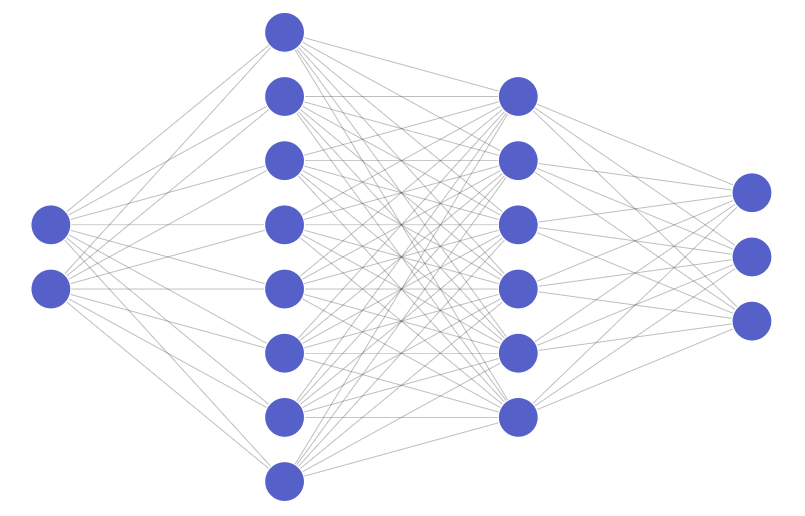

### Create the Q-Network: $\hat q(s,a| \theta)$

In [7]:
q_network = nn.Sequential(
    nn.Linear(state_dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, num_actions))

### Create the target Q-Network: $\hat q(s, a|\theta_{targ})$

In [8]:
target_q_network = copy.deepcopy(q_network).eval()

### Create the $\epsilon$-greedy policy: $\pi(s)$

In [9]:
def policy(state, epsilon=0.):
    if torch.rand(1) < epsilon:
        return torch.randint(num_actions, (1, 1))
    else:
        av = q_network(state).detach()
        return torch.argmax(av, dim=-1, keepdim=True)

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

<IPython.core.display.Javascript object>


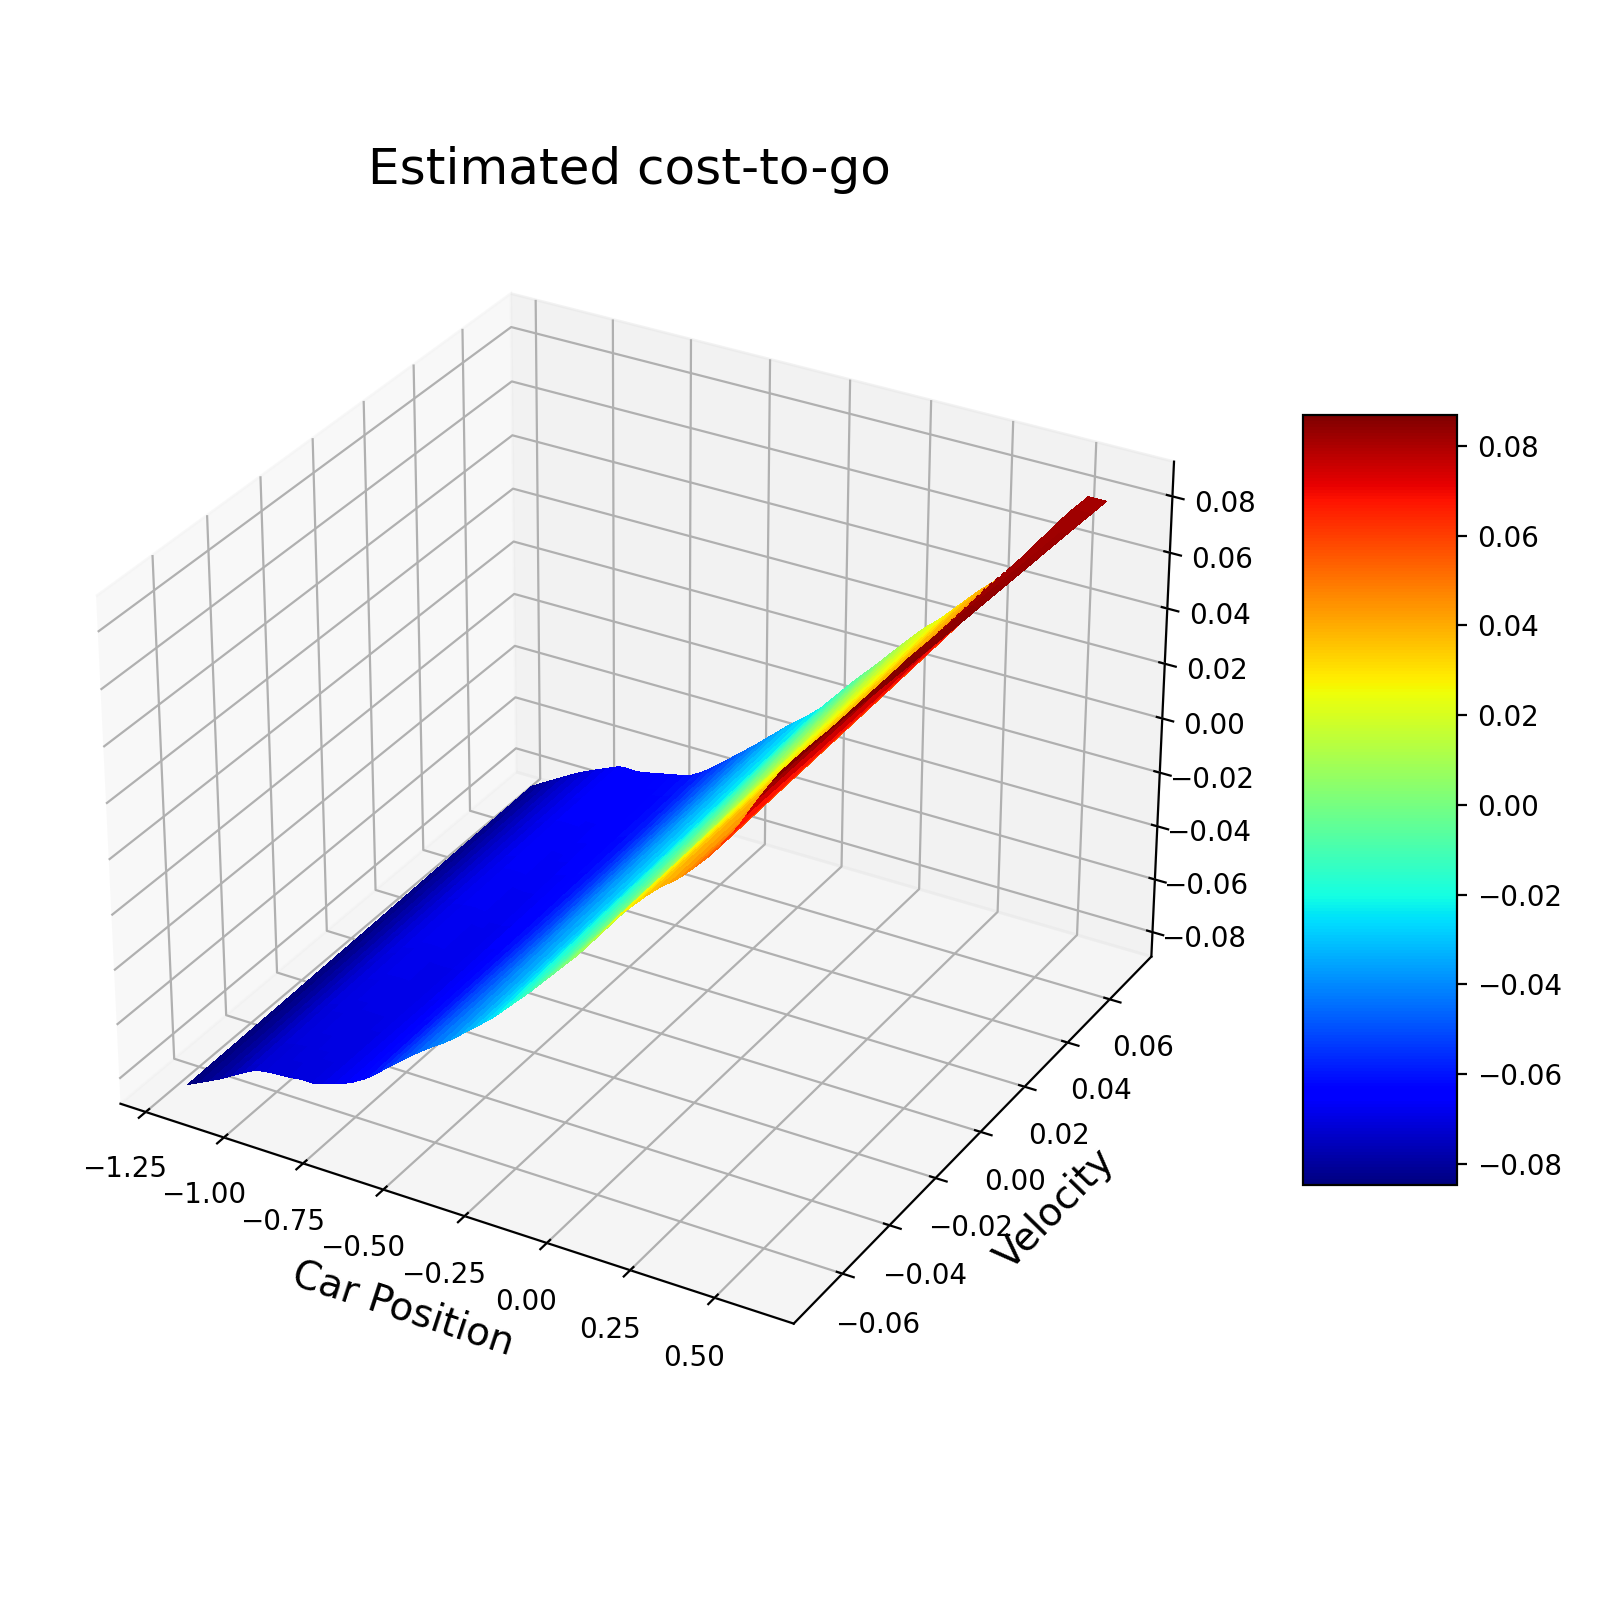

In [10]:
plot_cost_to_go(env, q_network, xlabel='Car Position', ylabel='Velocity')

## Create the Experience Replay buffer

<br>
<div style="text-align:center">
    <p>A simple buffer that stores transitions of arbitrary values, adapted from
    <a href="https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#training">this source.</a></p>
</div>

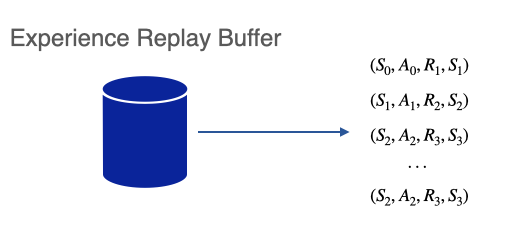


In [11]:
class ReplayMemory:

    def __init__(self, capacity=1000000):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def insert(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        assert self.can_sample(batch_size)

        batch = random.sample(self.memory, batch_size)
        batch = zip(*batch)
        return [torch.cat(items) for items in batch]

    def can_sample(self, batch_size):
        return len(self.memory) >= batch_size * 10

    def __len__(self):
        return len(self.memory)

## Implement the algorithm

</br></br>

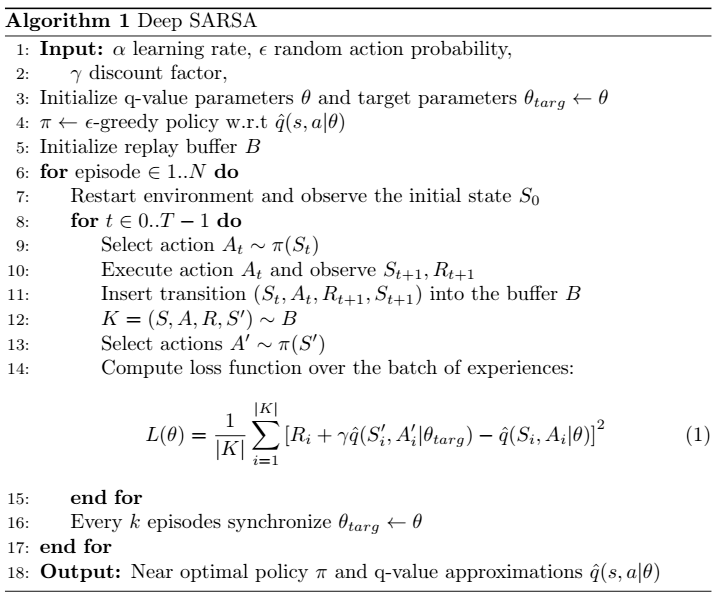

In [12]:
def deep_sarsa(q_network, policy, episodes, alpha=0.001, batch_size=32, gamma=0.99, epsilon=0.):
    optim = AdamW(q_network.parameters(), lr=alpha)
    memory = ReplayMemory()
    stats = {'MSE Loss': [], 'Returns': []}
    
    for episode in tqdm(range(1, episodes + 1)):
        state = env.reset()
        done = False
        ep_return = 0
        while not done:
            action = policy(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            memory.insert([state, action, reward, done, next_state])
            
            if memory.can_sample(batch_size):
                state_b, action_b, reward_b, done_b, next_state_b = memory.sample(batch_size)                
                qsa_b = q_network(state_b).gather(1, action_b)
                next_action_b = policy(next_state_b)
                next_qsa_b = target_q_network(next_state_b).gather(1, next_action_b)
                target_b = reward_b + ~done_b * gamma * next_qsa_b
                loss = F.mse_loss(qsa_b, target_b)
                q_network.zero_grad()
                loss.backward()
                optim.step()
                
                loss.item()
                stats['MSE Loss'].append(loss)
            
            state = next_state
            ep_return += reward.item()
        
        stats['Returns'].append(ep_return)
        
        if episode % 10 == 0:
            target_q_network.load_state_dict(q_network.state_dict())
        
    return stats

In [13]:
stats = deep_sarsa(q_network, policy, 1000, alpha=0.01, epsilon=0.0)

 11%|████▎                                   | 107/1000 [00:33<04:42,  3.16it/s]


KeyboardInterrupt: 

## Show results

### Plot execution stats

In [ ]:
plot_stats(stats)

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

In [ ]:
plot_cost_to_go(env, q_network, xlabel='Car Position', ylabel='Velocity')

### Show resulting policy: $\pi(s)$

In [ ]:
plot_max_q(env, q_network, xlabel='Car Position', ylabel='Velocity', 
           action_labels=['Back', 'Do nothing', 'Forward'])

### Test the resulting agent

In [ ]:
%matplotlib inline
test_agent(env, policy, episodes=2)

## Resources

[[1] Deep Reinforcement Learning with Experience Replay Based on SARSA](https://www.researchgate.net/publication/313803199_Deep_reinforcement_learning_with_experience_replay_based_on_SARSA)